<a href="https://colab.research.google.com/github/data-tamer2410/ds-movielens-recommender-system/blob/main/movielens_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from surprise.dataset import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, ShuffleSplit
from surprise.accuracy import rmse,mae
from surprise import SVD, SVDpp, NMF
from scipy.io import loadmat
%matplotlib inline

# Task 1.

Build a high-quality cobolarative recommender system using surprise.

# Solving task 1.

## Data loading and preparation.

In [3]:
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data,test_size=0.25,random_state=3)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


Dataset uploaded successfully!

It consists of a table with three columns:
- **user_id**: user id;

- **item_id**: id of movies;

- **rating**: the rating given by a certain user to a certain movie.

However, not all users rated all movies, which is why the table has missing values. Our goal is to predict these missing ratings. If a certain movie is highly rated, that movie can be recommended to him.

We also immediately divide the data into training and test data.

## Building and testing models.

### SVD

The first algorithm we will used is Singular Value Decomposition (SVD). SVD is a powerful mathematical technique used in linear algebra for decomposing a matrix into three other matrices. It plays a crucial role in various applications, including recommendation systems, data compression, and noise reduction.



**Selection of hyperparameters using Optuna.**

I run the tests several times, each time reducing the range of hyperparameters to find the best parameters.

In [ ]:
def objective(trial):
    n_factors = trial.suggest_int('n_factors',75,115)
    n_epochs = trial.suggest_int('n_epochs', 100, 130)
    lr_all = trial.suggest_float('lr_all', 0.004,0.006)
    reg_all = trial.suggest_float('reg_all', 0.1, 0.1204)

    algo = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)

    results = cross_validate(algo, data, measures=['rmse'], cv=3)

    return results['test_rmse'].mean()

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50)

In [ ]:
print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

Best params: {'n_factors': 104, 'n_epochs': 108, 'lr_all': 0.004101210489359503, 'reg_all': 0.11113407899883955}
Best RMSE: 0.9172164854103754


In [ ]:
svd = SVD(n_factors=104,n_epochs=108,lr_all=0.004101210489359503,
          reg_all=0.11113407899883955,random_state=23)

We will test the model on cross-validation and control test on test data, as quality assessment we will use RMSE and MAE.

We will save the results of cross-validation to compare the models at the end.

**CV test.**

In [ ]:
cv = ShuffleSplit(n_splits=5,random_state=23)

scores = cross_validate(svd,data=data,cv=cv)
rmse_mae_svd = scores['test_rmse'].mean(), scores['test_mae'].mean()

print(f"Result cv SVD:\nRMSE: {rmse_mae_svd[0]}\nMAE: {rmse_mae_svd[1]}")

Result cv SVD:
RMSE: 0.9104453226668714
MAE: 0.720513488180442


**Control test.**

In [ ]:
svd.fit(trainset)
y_pred = svd.test(testset)

print(rmse(y_pred))
print()
print(mae(y_pred))

RMSE: 0.9046
0.9045500281091379

MAE:  0.7159
0.715903741243391


### SVD++

**Selection of hyperparameters using GridSearch.**

I run the tests several times, each time reducing the range of hyperparameters to find the best parameters.

In [ ]:
param_grid = {
    'n_factors': [10,15],
    'n_epochs': [14,15,16],
    'lr_all': [0.006,0.007],
    'reg_all':[0.0009,0.001,0.002]
}
grid_search = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
grid_search.fit(data)

print(f"Best RMSE: {grid_search.best_score['rmse']}")
print(f"Best Params: {grid_search.best_params['rmse']}")

Best RMSE: 0.9203414536028466
Best Params: {'n_factors': 10, 'n_epochs': 14, 'lr_all': 0.006, 'reg_all': 0.001}


In [ ]:
svdpp = SVDpp(n_factors=10,n_epochs=14,lr_all=0.006,reg_all=0.001,random_state=23)

**CV test.**

In [ ]:
cv = ShuffleSplit(n_splits=3,random_state=23)

scores = cross_validate(svdpp,data=data,cv=cv)
rmse_mae_svdpp = scores['test_rmse'].mean(), scores['test_mae'].mean()

print(f"Result cv SVD++:\nRMSE: {rmse_mae_svdpp[0]}\nMAE: {rmse_mae_svdpp[1]}")

Result cv SVD++:
RMSE: 0.9136186384152346
MAE: 0.7168714876182051


**Control test.**

In [ ]:
svdpp.fit(trainset)
y_pred = svdpp.test(testset)

print(rmse(y_pred))
print()
print(mae(y_pred))

RMSE: 0.9060
0.9060394111805455

MAE:  0.7116
0.7116129729418912


### NMF

**Selection of hyperparameters using Optuna.**

I run the tests several times, each time reducing the range of hyperparameters to find the best parameters.

In [ ]:
def objective(trial):
    n_factors = trial.suggest_int('n_factors',10,160)
    n_epochs = trial.suggest_int('n_epochs',10,160)
    reg_pu = trial.suggest_float('reg_pu',0.0001,10)
    reg_qi = trial.suggest_float('reg_qi',0.0001,10)
    reg_bu = trial.suggest_float('reg_bu',0.0001,10)
    reg_bi = trial.suggest_float('reg_bi',0.0001,10)
    lr_bu = trial.suggest_float('lr_bu',0.0001,10)
    lr_bi = trial.suggest_float('lr_bi',0.0001,10)

    algo = NMF(n_factors=n_factors,n_epochs=n_epochs,reg_pu=reg_pu,reg_qi=reg_qi,reg_bu=reg_bu,
          reg_bi=reg_bi,lr_bu=lr_bu,lr_bi=lr_bi,random_state=23)

    results = cross_validate(algo,data,cv=3,measures=['rmse'])

    return results['test_rmse'].mean()

study = optuna.create_study(direction='minimize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=30,n_jobs=-1)

In [ ]:
print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

Best params: {'n_factors': 154, 'n_epochs': 148, 'reg_pu': 0.09759704430402118, 'reg_qi': 0.11841004464225398, 'reg_bu': 5.405666381883821, 'reg_bi': 12.740958639652561, 'lr_bu': 6.947714282733879, 'lr_bi': 4.88611242435783}
Best RMSE: 0.9252907837039027


In [ ]:
nmf = NMF(n_factors=154,n_epochs=148,reg_pu = 0.09759704430402118,reg_qi = 0.11841004464225398 , reg_bu = 5.405666381883821,
          reg_bi = 12.740958639652561, lr_bu = 6.947714282733879, lr_bi = 4.88611242435783,random_state=23)

**CV test.**

In [ ]:
cv = ShuffleSplit(n_splits=5,random_state=23)

scores = cross_validate(nmf,data=data,cv=cv)
rmse_mae_nmf = scores['test_rmse'].mean(), scores['test_mae'].mean()

print(f"Result cv NMF:\nRMSE: {rmse_mae_nmf[0]}\nMAE: {rmse_mae_nmf[1]}")

Result cv NMF:
RMSE: 0.9162534851364196
MAE: 0.7295657026190355


**Control test.**

In [ ]:
nmf.fit(trainset)
y_pred = nmf.test(testset)

print(rmse(y_pred))
print()
print(mae(y_pred))

RMSE: 0.9130
0.9129508854871363

MAE:  0.7267
0.7266570840122103


## Comparison of model performance.

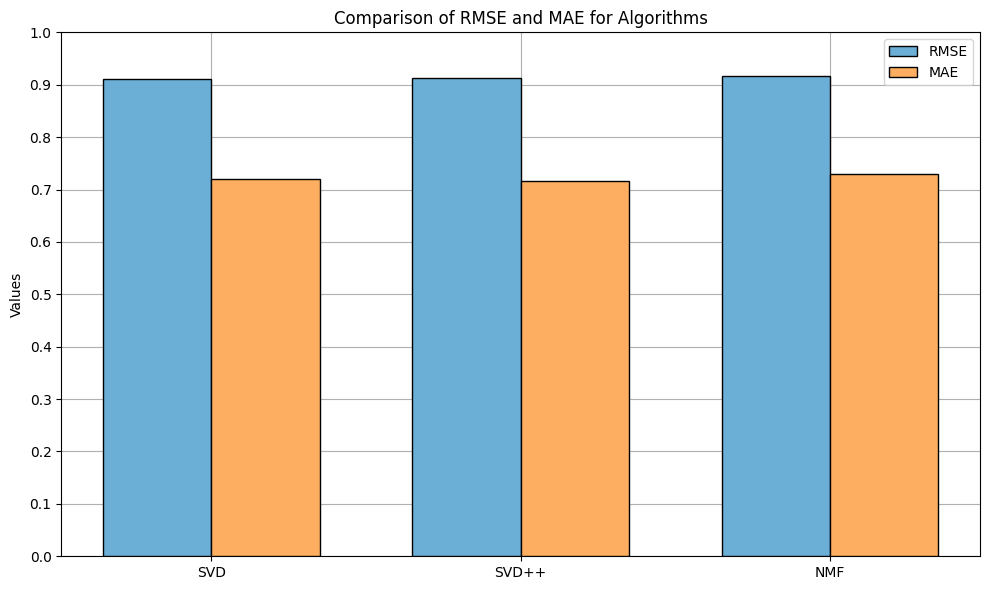

In [ ]:
rmse_values = rmse_mae_svd[0], rmse_mae_svdpp[0], rmse_mae_nmf[0]
mae_values = rmse_mae_svd[1], rmse_mae_svdpp[1], rmse_mae_nmf[1]

labels = ['SVD','SVD++','NMF']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - width / 2, rmse_values, width, label='RMSE', color='#6baed6',edgecolor='black',linewidth=1,zorder=3)
plt.bar(x + width / 2, mae_values, width, label='MAE', color='#fdae61',edgecolor='black',linewidth=1,zorder=3)

plt.ylabel('Values')
plt.title('Comparison of RMSE and MAE for Algorithms')
plt.xticks(x, labels)
plt.yticks(np.arange(0,np.max([rmse_values,mae_values]) + 0.1, 0.1))

plt.grid(zorder=0)
plt.tight_layout()
plt.legend()
plt.show()

## Recommendation of 10 movies for a user with ID 1484 using different models.

Let’s look at the model's results for a user with ID 1487 (a random number) for the first 10 movies they have not yet watched. We will recommend movies if they have a high predicted rating.

This is just an example of how the model works for a random user. In practice, these algorithms can be used to recommend a wide variety of movies to many different users.

In [ ]:
id_user = 1484
df = pd.DataFrame(np.array(data.raw_ratings)[:,:2],columns=['id_user','id_movie'])
all_movies = df['id_movie'].unique()
watching_movies = df[df['id_user'] == id_user]['id_movie']
not_watching_movies = all_movies[~pd.Series(all_movies).isin(watching_movies)]

In [ ]:
ids_10_movies = not_watching_movies[:10]
ratings_svd = [svd.predict(id_user,id_movie).est for id_movie in ids_10_movies]
ratings_svdpp = [svdpp.predict(id_user,id_movie).est for id_movie in ids_10_movies]
ratings_nmf = [nmf.predict(id_user,id_movie).est for id_movie in ids_10_movies]

high_rating_threshold = 4.0

for id_movie,r_svd,r_svdpp,r_nmf in zip(ids_10_movies,ratings_svd,ratings_svdpp,ratings_nmf):
    print(f'Movie: {id_movie}:\n'
          f'SVD: {r_svd:.2f} ({"not " if r_svd < high_rating_threshold else ""}recommended)\n'
          f'SVD++: {r_svdpp:.2f} ({"not " if r_svdpp < high_rating_threshold else ""}recommended)\n'
          f'NMF: {r_nmf:.2f} ({"not " if r_nmf < high_rating_threshold else ""}recommended)\n')

Movie: 242:
SVD: 3.91 (not recommended)
SVD++: 3.92 (not recommended)
NMF: 3.53 (not recommended)

Movie: 302:
SVD: 4.09 (recommended)
SVD++: 4.02 (recommended)
NMF: 3.53 (not recommended)

Movie: 377:
SVD: 2.31 (not recommended)
SVD++: 3.16 (not recommended)
NMF: 3.53 (not recommended)

Movie: 51:
SVD: 3.57 (not recommended)
SVD++: 3.51 (not recommended)
NMF: 3.53 (not recommended)

Movie: 346:
SVD: 3.51 (not recommended)
SVD++: 3.49 (not recommended)
NMF: 3.53 (not recommended)

Movie: 474:
SVD: 4.12 (recommended)
SVD++: 4.08 (recommended)
NMF: 3.53 (not recommended)

Movie: 265:
SVD: 3.81 (not recommended)
SVD++: 3.75 (not recommended)
NMF: 3.53 (not recommended)

Movie: 465:
SVD: 3.49 (not recommended)
SVD++: 3.70 (not recommended)
NMF: 3.53 (not recommended)

Movie: 451:
SVD: 3.39 (not recommended)
SVD++: 3.57 (not recommended)
NMF: 3.53 (not recommended)

Movie: 86:
SVD: 3.82 (not recommended)
SVD++: 4.03 (recommended)
NMF: 3.53 (not recommended)



## Conclusion.

In this project, we developed a collaborative recommender system utilizing several algorithms, including Singular Value Decomposition (SVD), SVD++, and Non-negative Matrix Factorization (NMF). By leveraging the Surprise library, we efficiently processed the MovieLens 100K dataset, which provided valuable insights into user preferences and movie ratings.

After hyperparameter optimization using techniques such as Optuna for SVD and NMF and GridSearchCV for SVD++, we achieved competitive performance metrics. The cross-validation results revealed the following metrics for each model:

- **SVD:** RMSE of 0.910 and MAE of 0.720
- **SVD++:** RMSE of 0.914 and MAE of 0.717
- **NMF:** RMSE of 0.916 and MAE of 0.730

Although SVD yielded the best results in terms of RMSE and MAE, all models demonstrated similar performance levels, indicating their effectiveness in making recommendations. The model's predictions allow us to recommend movies to users based on their previously rated films, enhancing user experience by providing personalized suggestions.

Overall, this project not only highlighted the importance of collaborative filtering techniques in building recommendation systems but also provided practical experience in implementing and evaluating these algorithms. The insights gained here can be further applied to refine and improve recommendation strategies in real-world applications.


# Tasks with an asterisk.

It is necessary to independently build a collaborative filtering algorithm.

# Solving the problem with an asterisk.

## Loading and preparing data.

In [10]:
data = loadmat('movies.mat')
Y, R = data['Y'], data['R']

The dataset has been successfully downloaded!  

**Y** - consists of a ratings table where rows represent users and columns represent movies. However, not all users have rated all movies, resulting in missing values in the table. Our goal is to predict these missing ratings. If a rating given by a user for a specific movie is high, that movie can be recommended to the user.

**R**  - is a matrix with the same dimension where there are only two values.
1 if the user rated the movie, 0 otherwise.

In [11]:
# We divide the rating matrix into three columns: id_user, id_movie, rating.
# This is done in order to divide the data into training and test data using the surprise function.
df_Y = pd.DataFrame(Y)
df_Y.index.name = 'id_user'
df_Y.columns.name = 'id_movie'
df_Y = df_Y.stack().reset_index()
df_Y.rename(columns={0:'rating'},inplace=True)

In [12]:
reader = Reader()

dataset = Dataset.load_from_df(df_Y,reader)
trainset, testset = train_test_split(dataset,test_size=0.25,random_state=34)

In [13]:
# Functions to return training and test data to a standard format.
def trainset_to_np(trainset):
    ratings = trainset.build_testset()
    trainset_df = pd.DataFrame(ratings, columns=['id_user','id_movie','rating'])
    trainset_df['id_user'] = trainset_df['id_user'].apply(lambda x: trainset.to_raw_uid(x))
    trainset_df['id_movie'] = trainset_df['id_movie'].apply(lambda x: trainset.to_raw_iid(x))
    trainset_df = trainset_df.pivot(index='id_user',columns='id_movie',values='rating')
    trainset_df.fillna(0,inplace=True)
    R_trainset_df = np.where(trainset_df>0,1,0)
    return trainset_df.values, R_trainset_df

def testset_to_np(testset):
    testset_df = pd.DataFrame(testset,columns=['id_user','id_movie','rating'])
    testset_df['id_user'] = testset_df['id_user'].apply(lambda x: trainset.to_raw_uid(x))
    testset_df['id_movie'] = testset_df['id_movie'].apply(lambda x: trainset.to_raw_iid(x))
    testset_df = testset_df.pivot(index='id_user',columns='id_movie',values='rating')
    testset_df.fillna(0,inplace=True)
    R_testset_df = np.where(testset_df>0,1,0)
    return testset_df.values, R_testset_df

In [14]:
# We convert training and test data into a standard format convenient for us.
trainset_np, R_trainset_np = trainset_to_np(trainset)
testset_np, R_testset_np = testset_to_np(testset)

## Implementation of collaborative filtering from scratch.

In [15]:
def predict(P,Q,study=False):
    return np.clip((P @ Q.T),1,5) if not study else (P @ Q.T)

def loss_func_with_reg(R,P,Q,Y,reg_param):
    mask = R > 0
    y_pred = predict(P,Q,study=True)[mask]
    Y = Y[mask]
    m = Y.size
    mse = (1 / 2) * np.mean((y_pred - Y) ** 2)
    reg = (reg_param / 2) * (np.sum(P**2) + np.sum(Q**2))
    return  mse  + reg

def gradient_step(R,P,Q,Y,alpha,reg_param):
    mask = R == 0
    y_pred = predict(P,Q,study=True)
    error = y_pred - Y
    error[mask] = 0

    P_grad = error @ Q + reg_param * P
    P -= alpha * P_grad

    Q_grad = error.T @ P + reg_param * Q
    Q -= alpha * Q_grad
    return P, Q

def mae_score(R,P,Q,Y):
    mask = R > 0
    y_pred = predict(P,Q)[mask]
    Y = Y[mask]
    mae = np.mean(np.abs(y_pred - Y))
    return mae

def rmse_score(R,P,Q,Y):
    mask = R > 0
    y_pred = predict(P,Q)[mask]
    Y = Y[mask]
    rmse = np.sqrt(np.mean((y_pred - Y) ** 2))
    return rmse

## Selection of hyperparameters.

In [ ]:
def objective(trail):
    n_features = trail.suggest_int('n_features',70,75)
    n_iters = trail.suggest_int('n_iters', 390,445)
    alpha = trail.suggest_float('alpha',0.00003,0.000035)
    reg_param = trail.suggest_float('reg_param',44,50)

    cv = ShuffleSplit(n_splits=3,test_size=0.2,random_state=32)

    results_rmse = []

    for train,test in cv.split(dataset):
        train_np, R_train_np = trainset_to_np(train)
        test_np, R_test_np = testset_to_np(test)

        P = np.random.rand(train_np.shape[0],n_features)
        Q = np.random.rand(train_np.shape[1],n_features)

        for _ in range(n_iters):
            P, Q = gradient_step(R_train_np,P,Q,train_np,alpha,reg_param)

        results_rmse.append(rmse_score(R_test_np,P,Q,test_np))

    return np.mean(results_rmse)

study = optuna.create_study(direction='minimize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=30,n_jobs=-1,show_progress_bar=True)

In [ ]:
print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

Best params: {'n_features': 70, 'n_iters': 405, 'alpha': 3.2349119733699644e-05, 'reg_param': 45.54877502634756}
Best RMSE: 1.3171355550072654


## Model training.

In [18]:
alpha =  3.2349119733699644e-05
reg_param = 45.54877502634756
n_iters = 405
n_features = 70

P = np.random.rand(trainset_np.shape[0],n_features)
Q = np.random.rand(trainset_np.shape[1],n_features)

# Each iteration we will store the values ​​of the loss function, RMSE and MAE.
loss_list = []
rmse_list = []
mae_list = []

for i in range(n_iters):
    loss_list.append(loss_func_with_reg(R_trainset_np,P,Q,trainset_np,reg_param))
    rmse_list.append(rmse_score(R_trainset_np,P,Q,trainset_np))
    mae_list.append(mae_score(R_trainset_np,P,Q,trainset_np))
    P, Q = gradient_step(R_trainset_np,P,Q,trainset_np,alpha,reg_param)
    if any((i % 100 == 0,i == n_iters - 1)):
        print(f'Itere: {i}\nLoss: {loss_list[-1]}\nRMSE: {rmse_list[-1]}\nMAE: {mae_list[-1]}\n')

Itere: 0
Loss: 1399470.3158560353
RMSE: 1.852167936321661
MAE: 1.4709231340906679

Itere: 100
Loss: 707958.4064158531
RMSE: 1.4188168613391208
MAE: 1.1363128747562734

Itere: 200
Loss: 521057.62796925317
RMSE: 1.1750977698592922
MAE: 0.9468122953723207

Itere: 300
Loss: 400432.56942832493
RMSE: 1.0503498883775615
MAE: 0.8529760729432625

Itere: 400
Loss: 317472.80049880716
RMSE: 1.0175171127446736
MAE: 0.829638354878812

Itere: 404
Loss: 314730.8089543116
RMSE: 1.0173788887391515
MAE: 0.829563980138492



## Algorithm performance evaluation.

### Cross-validation and control test.

In [ ]:
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=42)

res_rmse = []
res_mae = []

for train_s, test_s in cv.split(dataset):
    train_s_np,R_train_s_np = trainset_to_np(train_s)
    test_s_np,R_test_s_np = testset_to_np(test_s)

    P = np.random.rand(train_s_np.shape[0],n_features)
    Q = np.random.rand(train_s_np.shape[1],n_features)

    for _ in range(n_iters):
        P, Q = gradient_step(R_train_s_np,P,Q,train_s_np,alpha,reg_param)
    res_rmse.append(rmse_score(R_test_s_np,P,Q,test_s_np))
    res_mae.append(mae_score(R_test_s_np,P,Q,test_s_np))
print(f'CV results:\nRMSE: {np.mean(res_rmse)}\nMAE:{np.mean(res_mae)}')

CV results:
RMSE: 1.302003178676198
MAE:1.061560118267319


In [ ]:
print(f'Finaly results:\nRMSE: {rmse_score(R_testset_np,P,Q,testset_np)}\n'
      f'MAE: {mae_score(R_testset_np,P,Q,testset_np)}')

Finaly results:
RMSE: 1.3237721546259138
MAE: 1.0819947085828954


### Construction of graphs, model work.

We compare 15 predicted ratings with target values.

In [ ]:
y_pred = predict(P,Q)
scores = pd.DataFrame({'y_pred':y_pred[R != 0][:15],'y_true':Y[R != 0][:15]})
scores.index.name = 'movie_id'

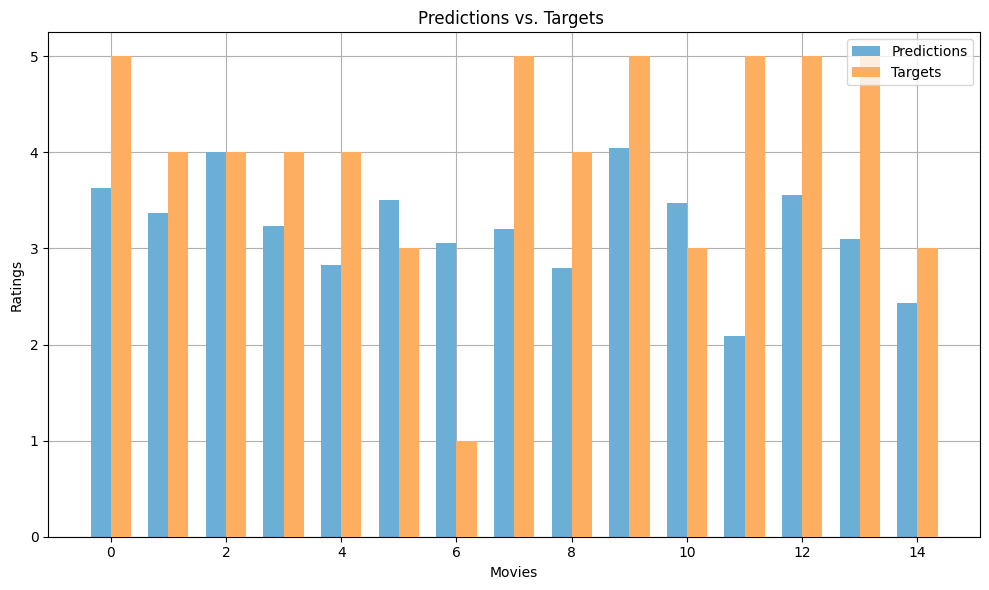

In [ ]:
plt.figure(figsize=(10, 6))

x = scores.index
width = 0.35

plt.bar(x - width / 2, scores['y_pred'],width=width,color='#6baed6',label='Predictions',zorder=2)
plt.bar(x + width / 2, scores['y_true'],width=width,color='#fdae61',label='Targets',zorder=3)

plt.title('Predictions vs. Targets ')
plt.ylabel('Ratings')
plt.xlabel('Movies')

plt.tight_layout()
plt.legend()
plt.grid(zorder=1)
plt.show()

Let's look at the learning loss function, if it decreases, then the algorithm optimizes its parameters.

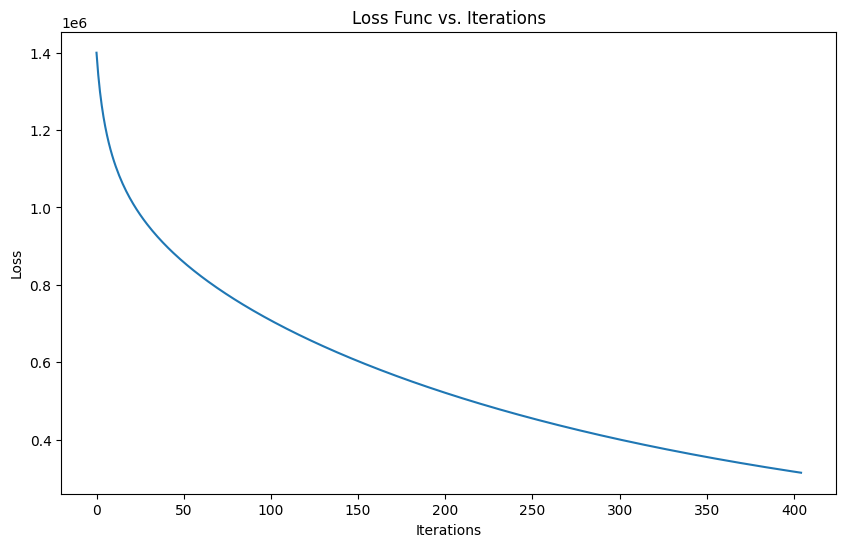

In [20]:
plt.figure(figsize=(10, 6))

plt.plot(range(n_iters), loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Func vs. Iterations')
plt.show()

Let's look at the RMSE during training, if it decreases, the algorithm will optimize its parameters.

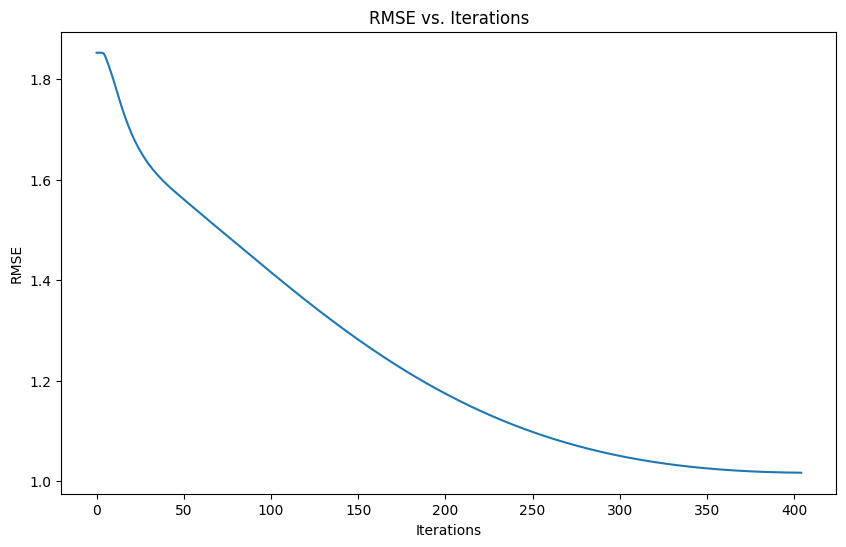

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(range(n_iters), rmse_list)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE vs. Iterations')
plt.show()

Let's look at the MAE during training, if it decreases, the algorithm will optimize its parameters.

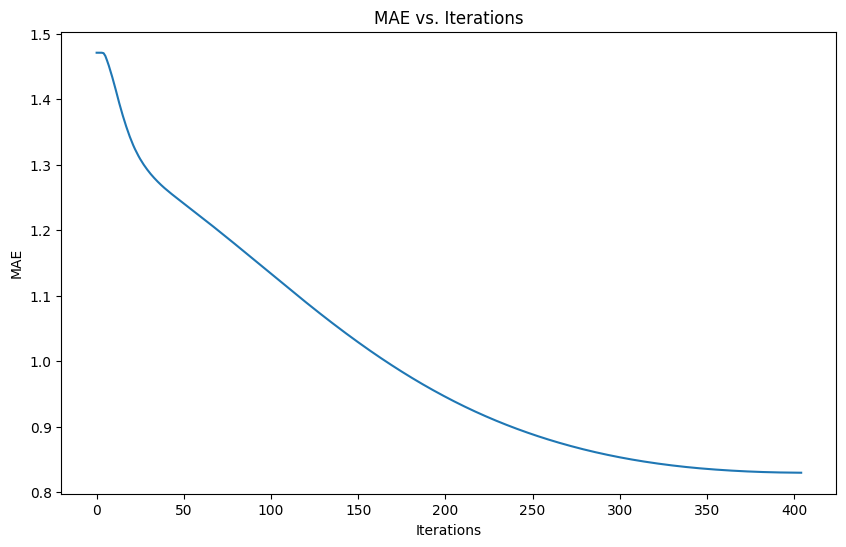

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(range(n_iters), mae_list)
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('MAE vs. Iterations')
plt.show()

## Recommendation of movies to users.

In [21]:
y_pred = predict(P,Q)

In [22]:
y_pred = pd.DataFrame(y_pred)
y_pred.index.name = 'user_id'
y_pred.columns.name = 'movie_id'

In [44]:
y_pred[R == 1] = 0 # We only need ratings that have not been given before (the user has not rated this movie).
hight_rating = y_pred[y_pred >= 3] # Filter by high scores.

u_m_ids = hight_rating.stack().reset_index() # We get combinations of user indexes and movies that they are most likely to like.
u_m_ids.drop(columns=0,inplace=True) # We will also remove the extra column with the rating.

indices = np.random.choice(u_m_ids.shape[0],size=10,replace=False)

for i in indices:
    print(f"For User {u_m_ids.loc[i,'user_id']} id "
    f"recommended: Movie {u_m_ids.loc[i,'movie_id']} id;\n")

For User 35 id recommended: Movie 593 id;

For User 883 id recommended: Movie 278 id;

For User 406 id recommended: Movie 674 id;

For User 1547 id recommended: Movie 233 id;

For User 1434 id recommended: Movie 344 id;

For User 1498 id recommended: Movie 520 id;

For User 1475 id recommended: Movie 430 id;

For User 1525 id recommended: Movie 550 id;

For User 1020 id recommended: Movie 827 id;

For User 947 id recommended: Movie 655 id;



## Conclusion.

In this project, a collaborative filtering algorithm was successfully implemented to recommend movies to users. The dataset included a matrix of user ratings across various movies (Y) and a binary matrix (R) indicating whether a rating was given. The project involved data preparation, model building from scratch, hyperparameter optimization, and evaluation of recommendation quality.

Hyperparameters were tuned using cross-validation and Optuna, which helped minimize the RMSE on the test data. Cross-validation results showed an average RMSE of 1.30 and a Mean Absolute Error (MAE) of 1.06. On the final test set, the model achieved an RMSE of 1.32 and an MAE of 1.08, indicating good model quality and stability in predicting user ratings.

During training, the loss function, RMSE, and MAE all decreased, demonstrating successful parameter optimization.

In summary, the developed model effectively addresses the task of predicting user preferences, enabling movie recommendations based on high predicted ratings for films the user has not yet rated.